In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()  # 1

In [39]:
df = pd.read_csv("/Users/harshit/projects/ai_projects/momentum_trading_testing/eur_data.csv")
df['time'] = df['time'].astype('datetime64[s]')
df = df.set_index('time')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2373 entries, 2018-11-01 04:00:00 to 2018-11-02 20:59:00
Data columns (total 6 columns):
complete    2373 non-null bool
volume      2373 non-null int64
open        2373 non-null float64
high        2373 non-null float64
low         2373 non-null float64
close       2373 non-null float64
dtypes: bool(1), float64(4), int64(1)
memory usage: 113.6 KB


In [40]:
df = df.drop(["complete", "volume"], axis=1)

In [41]:
df.head()

,open,high,low,close
time,,,,
2018-11-01 04:00:00,1.13458,1.13466,1.13458,1.13458
2018-11-01 04:01:00,1.13456,1.13462,1.13456,1.13461
2018-11-01 04:02:00,1.13458,1.13458,1.13452,1.13455
2018-11-01 04:03:00,1.13456,1.13462,1.13455,1.13460
2018-11-01 04:04:00,1.13456,1.13458,1.13446,1.13458


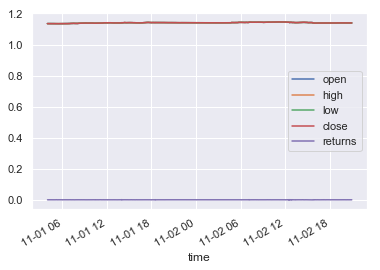

In [46]:
cols = df.columns[df.dtypes.eq(object)]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=0)
df.plot()

In [43]:
df['returns'] = np.log(df['close'] / df['close'].shift(1))  # 12
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2373 entries, 2018-11-01 04:00:00 to 2018-11-02 20:59:00
Data columns (total 5 columns):
open       2373 non-null float64
high       2373 non-null float64
low        2373 non-null float64
close      2373 non-null float64
returns    2372 non-null float64
dtypes: float64(5)
memory usage: 111.2 KB


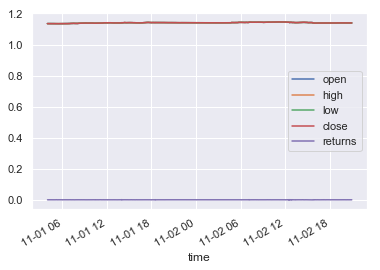

In [45]:
df.plot()

In [48]:
cols = []
for momentum in [15, 30, 60, 120]:
    col = 'position_%s' % momentum
    df[col] = np.sign(df['returns'].rolling(momentum).mean())
    cols.append(col)

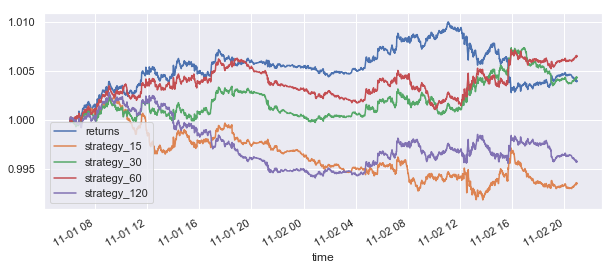

In [50]:
strats = ['returns']  # 19

for col in cols:  # 20
    strat = 'strategy_%s' % col.split('_')[1]  # 21
    df[strat] = df[col].shift(1) * df['returns']  # 22
    strats.append(strat)  # 23

df[strats].dropna().cumsum().apply(np.exp).plot(figsize=(10,4)) # 24
plt.show()

In [52]:
df.tail()

,open,high,low,close,returns,position_15,position_30,position_60,position_120,strategy_15,strategy_30,strategy_60,strategy_120
time,,,,,,,,,,,,,
2018-11-02 20:55:00,1.13874,1.13896,1.13872,1.13888,0.000114,-1.0,-1.0,-1.0,1.0,-0.000114,-0.000114,-0.000114,0.000114
2018-11-02 20:56:00,1.13889,1.13890,1.13858,1.13877,-0.000097,-1.0,-1.0,-1.0,1.0,0.000097,0.000097,0.000097,-0.000097
2018-11-02 20:57:00,1.13878,1.13878,1.13862,1.13863,-0.000123,-1.0,-1.0,-1.0,1.0,0.000123,0.000123,0.000123,-0.000123
2018-11-02 20:58:00,1.13864,1.13882,1.13862,1.13876,0.000114,-1.0,-1.0,-1.0,1.0,-0.000114,-0.000114,-0.000114,0.000114
2018-11-02 20:59:00,1.13877,1.13889,1.13868,1.13875,-0.000009,-1.0,-1.0,-1.0,1.0,0.000009,0.000009,0.000009,-0.000009


In [54]:
sharpe_ratio = df['strategy_60'].mean() / df['strategy_60'].std()
sharpe_ratio

0.020424288090750052

In [57]:
A_sharpe_ratio = (252**0.5) * sharpe_ratio

In [58]:
A_sharpe_ratio

0.3242255219619771

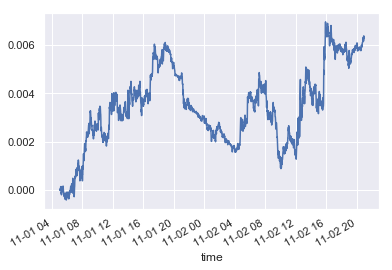

In [60]:
df['strategy_60'].cumsum().plot()

In [61]:
import quandl as q

In [65]:
q.ApiConfig.api_key = "yuqp72Y_-GpAsrjQEXfL"

In [71]:
data = q.get("EOD/AAPL", start_date="2010-01-01", end_date="2018-11-30")

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2245 entries, 2010-01-04 to 2018-11-30
Data columns (total 12 columns):
Open          2245 non-null float64
High          2245 non-null float64
Low           2245 non-null float64
Close         2245 non-null float64
Volume        2245 non-null float64
Dividend      2245 non-null float64
Split         2245 non-null float64
Adj_Open      2245 non-null float64
Adj_High      2245 non-null float64
Adj_Low       2245 non-null float64
Adj_Close     2245 non-null float64
Adj_Volume    2245 non-null float64
dtypes: float64(12)
memory usage: 228.0 KB


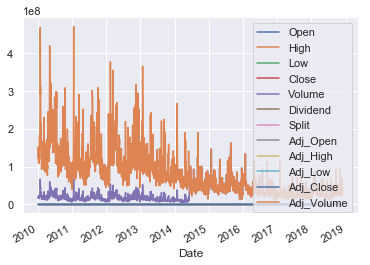

In [73]:
data.plot()

### The strategy rules are as follows:
1. Yesterday must have been a low day with a drop of at least 0.25%
2. If AAPL opens down by more than 0.1% today, go long and exit on close.

In [79]:
# cols = []
strat_data = pd.DataFrame(index=data.index)
strat_data['cc'] = data['Close'].pct_change()*100
strat_data['co'] = (data['Open']/data['Close'].shift(1)-1)*100
strat_data['oc'] = (data['Close']/data['Open']-1)*100
strat_data.head()

,cc,co,oc
Date,,,
2010-01-04,NaN,NaN,0.271752
2010-01-05,0.172889,0.275688,-0.102516
2010-01-06,-1.590633,0.000000,-1.590633
2010-01-07,-0.184860,0.369721,-0.552538
2010-01-08,0.664830,-0.132966,0.798859


In [80]:
sharpe_ratio = strat_data['co'].mean() / strat_data['co'].std()
sharpe_ratio

0.029310545360186943

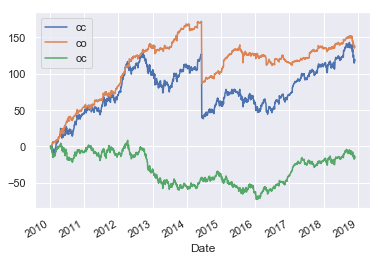

In [78]:
strat_data.cumsum().plot()

As can be seen from the plot above - Close to Open has the best returns 

In [82]:
s = np.random.normal(1,1,100)

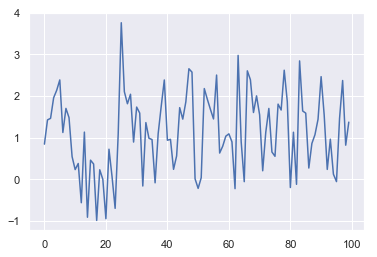

In [83]:
plt.plot(s)

In [84]:
np.mean(s)

1.1274228241668698

In [85]:
np.std(s)

0.9542603437060011

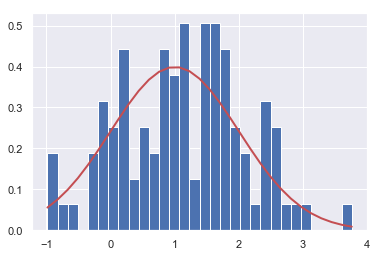

In [92]:
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(1 * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - 1)**2 / (2 * 1**2) ),
          linewidth=2, color='r')
plt.show()